In [1]:
import matplotlib.pyplot as plt
import numpy as np
import eispac
import astropy.units as u
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from specutils.manipulation import SplineInterpolatedResampler
import h5py

In [4]:
data_filepath = '../../src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.data.h5'
ch_fexii_195_file = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.1c-0.fit.h5"

In [5]:
ch_fexii_195_fitres = eispac.read_fit(ch_fexii_195_file)
ch_fexii_195_intmap = ch_fexii_195_fitres.get_map(component=0, measurement='intensity')

Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_12_195_119.1c-0.fit.h5
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [6]:
ch_shiftx, ch_shifty = -4.09618*u.arcsec, -2.50511*u.arcsec
ch_fexii_195_intmap_shifted = ch_fexii_195_intmap.shift(ch_shiftx, ch_shifty)
ch_fexii_195_intmap_shifted.bottom_left_coord

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2017-08-21T12:56:10.500, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T12:56:10.500, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., 6.91859397, 1.51333271e+11)>): (Tx, Ty) in arcsec
    (129.66899773, 665.36403063)>

In [7]:
def interp_window_slit_tilt(data,err,wvl):
    data_shape = data.shape
    data_interp = np.zeros(data_shape)
    err_interp = np.zeros(data_shape)
    for ii in range(data_shape[0]):
        for jj in range(data_shape[1]):
            interp_spline = SplineInterpolatedResampler()
            spec_grid = data[ii,jj,:]
            bad_mask = np.ones(len(spec_grid), dtype=bool)
            bad_mask[np.where(spec_grid < -100)] = False
            spec_grid = spec_grid[bad_mask,]*u.adu
            wvl_grid = wvl[ii,jj,:]
            wvl_grid = wvl_grid[bad_mask,]*u.AA
            wvl_grid_interp = wvl[0,0,:]*u.AA
            err_grid = err.array[ii,jj,:]
            data_err = StdDevUncertainty(err_grid[bad_mask,])
            input_spec = Spectrum1D(flux=spec_grid,spectral_axis=wvl_grid,uncertainty=data_err)
            interp_spec = interp_spline(input_spec,wvl_grid_interp)

            data_interp[ii,jj,:] = interp_spec.flux.value
            err_interp[ii,jj,:] = interp_spec.uncertainty.array
    
    return data_interp, err_interp

In [14]:
with h5py.File("../../sav/EIS/NPCHDB/NPCHDB_tiltcorr_crop.h5", 'w') as hf:
    for ii in range(1):
        data_cube = eispac.read_cube(data_filepath,ii)
        data_cube_interp, err_cube_interp = interp_window_slit_tilt(data_cube.data[:,:78,:],data_cube.uncertainty[:,:78,:],data_cube.wavelength[:,:78,:])

        df_data_cube = hf.create_dataset("data_cube_{:d}".format(ii),  data=data_cube_interp)
        df_err_cube = hf.create_dataset("err_cube_{:d}".format(ii),  data=err_cube_interp)
        df_wvl_cube = hf.create_dataset("wvl_cube_{:d}".format(ii),  data=data_cube.wavelength[0,0,:])
        df_ccd_offset = hf.create_dataset("ccd_offset_{:d}".format(ii),  data=data_cube.meta["ccd_offset"])
        df_slit_width = hf.create_dataset("slit_width_{:d}".format(ii), data=data_cube.meta["slit_width"])

    df_fexii_bottom_left = hf.create_dataset("fexii_195_bottom_left", data=np.array([ch_fexii_195_intmap_shifted.bottom_left_coord.Tx.value,
                                                                                     ch_fexii_195_intmap_shifted.bottom_left_coord.Ty.value]))
    

Data file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.data.h5
Header file,
   /Users/yjzhu/Desktop/Solar/Eclipse2017/src/EIS/level1/NPCH_DB/data_eis/eis_20170821_110818.head.h5
Found window 0
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


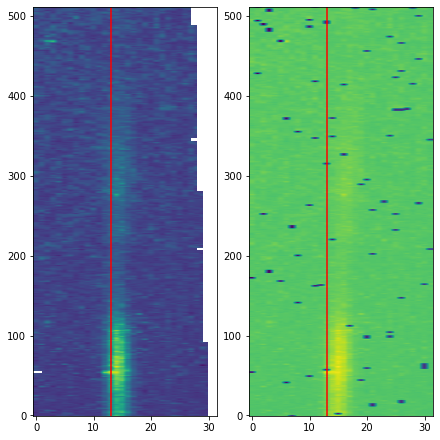

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,6),constrained_layout=True)
ax1.imshow(data_cube_interp[:,20,:], origin="lower",aspect="auto")
ax2.imshow(data_cube.data[:,20,:], origin="lower",aspect="auto")

for ax_ in (ax1,ax2):
    ax_.axvline(13,color="red")